### Note: The data for co-registration should be utm projected.

In [1]:
import os
os.chdir('..')
import numpy as np
from notebooks import config
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow
from utils.crop_to_extent import crop_to_extent
from utils.raster_vec import vec2mask


In [2]:
path_master = config.root_proj + '/data/dem/srtm-c/SRTMGL3_v1/srtml3_wgs84V_utm_align.tif'
# path_slave = config.root_proj + '/data/dem/tandem-x/tandem_wkunlun_upsam_utm_align.tif'
path_slave = config.root_proj + '/data/dem/srtm-x/srtm_x_utm.tif'
path_img = config.root_proj + '/data/rsimg/l8_kunlun_20200914.tif'



In [3]:
img_master, img_master_info = readTiff(path_master)
img_slave, img_slave_info = readTiff(path_slave)
rs_img, rs_img_info = readTiff(path_img)
print('master dem shape:',   img_master.shape, 'extent:', img_master_info['geoextent'])
print('slave dem shape:', img_slave.shape, 'extent',  img_slave_info['geoextent'])


master dem shape: (3968, 6282) extent: (419391.6113126002, 585919.5646432166, 3862794.8176520756, 3967981.5287020416)
slave dem shape: (3968, 6282) extent (419391.61130260024, 585919.5646253139, 3862794.8176692203, 3967981.5287141944)


### Check dem image

Text(0.5, 1.0, 'slave dem')

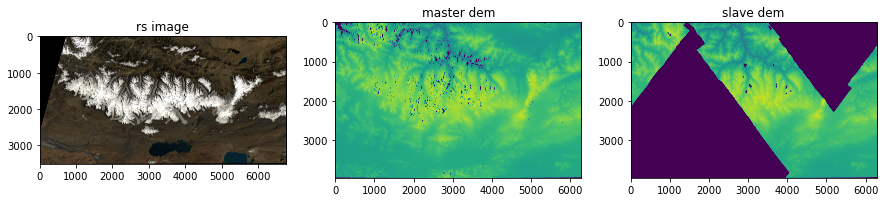

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
imgShow(rs_img)
plt.title('rs image')
plt.subplot(1,3,2)
plt.imshow(img_master, vmin=2000, vmax=7000)
plt.title('master dem')
plt.subplot(1,3,3)
plt.imshow(img_slave, vmin=2000, vmax=7000)
plt.title('slave dem')


### 1. Mask dem with rgi glacier and jrc water data

In [5]:
path_water_jrc = config.root_proj + '/data/water_jrc/wkl_water_jrc_utm.tif'      # jrc water map
path_rgi_1305 = config.root_proj + '/data/rgi/rgi60_1305/rgi60_1305.shp'     # rgi glacier data


### 1.1 Water mask

In [6]:
water_jrc, water_jrc_info = readTiff(path_water_jrc)
extent_base = img_master_info['geoextent']
size_base = [img_master_info['row'], img_master_info['col']]
water_jrc_crop = crop_to_extent(path_img=path_water_jrc, \
                                  extent_target=extent_base, size_target=size_base)
water_jrc_crop = np.ma.masked_where(water_jrc_crop>50, water_jrc_crop)


### 1.2 Glacier mask

In [7]:
rgi_img = vec2mask(path_raster=path_master, path_vec=path_rgi_1305, path_save=None)
rgi_img = np.ma.masked_equal(rgi_img, 1)


### 1.3 Nodata mask (optional)

In [8]:
nodata_mask = np.ma.masked_equal(img_slave, 0)

In [9]:
## merge the water and glacier mask
mask = np.logical_or.reduce((water_jrc_crop.mask, rgi_img.mask, nodata_mask.mask))


### Apply the mask

In [10]:
img_master_masked = np.ma.array(img_master, mask=mask, fill_value=0).astype(np.float32).filled(np.nan)
img_slave_masked = np.ma.array(img_slave, mask=mask, fill_value=0).astype(np.float32).filled(np.nan)


Text(0.5, 1.0, 'masked slave image')

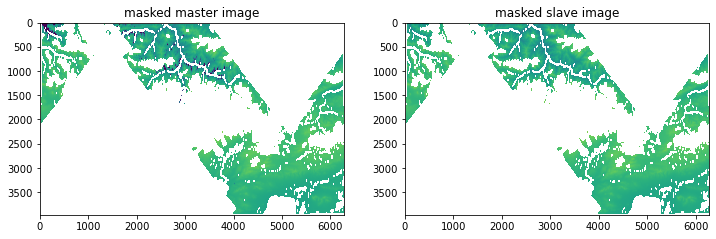

In [11]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(img_master_masked, vmin=2000, vmax=7000)
plt.title('masked master image')
plt.subplot(1,2,2)
plt.imshow(img_slave_masked, vmin=2000, vmax=7000)
plt.title('masked slave image')


### Co-registration (take srtm-c as reference) by using method proposed by [Nuth and Kääb (2011)](https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html)
### **Using pybob**

In [12]:
import pybob.coreg_tools as ct
from pybob.GeoImg import GeoImg
master_dem = GeoImg(path_master)   # master
slave_dem = GeoImg(path_slave)
slave_dem.img[slave_dem.img==0] = np.nan
# slave_dem = slave_dem.reproject(master_dem)   # 
slope_geo = ct.get_slope(master_dem)  # calculate slope from master DEM, scale is 111120 if using wgs84 projection
aspect_geo = ct.get_aspect(master_dem) # calculate aspect from master DEM



Text(0.5, 1.0, 'aspect image')

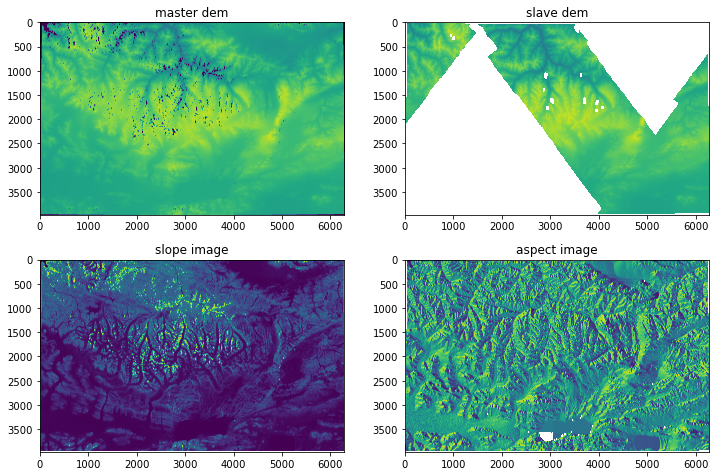

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(master_dem.img, vmin=2000, vmax=7000)
plt.title('master dem')
plt.subplot(2,2,2)
plt.imshow(slave_dem.img, vmin=2000, vmax=7000)
plt.title('slave dem')
plt.subplot(2,2,3)
plt.imshow(slope_geo.img, vmin=0, vmax=90)
plt.title('slope image')
plt.subplot(2,2,4)
plt.imshow(aspect_geo.img, vmin=0, vmax=360)
plt.title('aspect image')


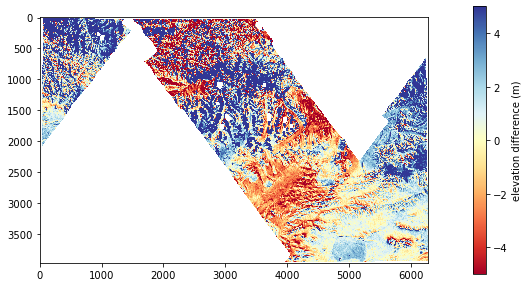

In [15]:
init_dh_geo = slave_dem.copy(new_raster=slave_dem.img-master_dem.img) # initial dem difference (a new GeoImg dataset)
plt.figure(figsize=(8,8))
plt.imshow(init_dh_geo.img, vmin=-5, vmax=5, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.1); 
cb.set_label('elevation difference (m)')



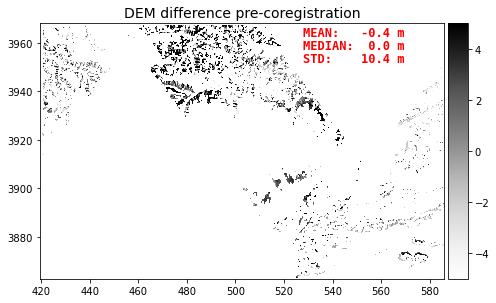

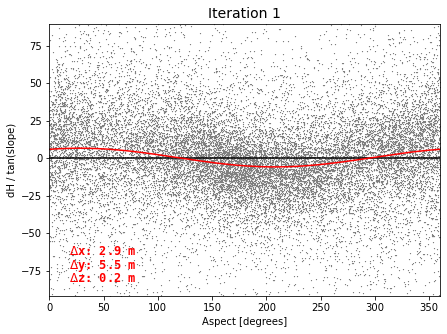

In [16]:
## 1. copy the slave_dem as the processing dem
slave_proc = slave_dem.copy() # make a copy of the slave DEM
## 2. pre-processing: data mask by provided mask data and the calculated outlier values; 
## xdata->masked aspect, ydata->masked dH, sdata->masked tan(a)
dH, xdata, ydata, sdata = ct.preprocess(mask, slope_geo.img, aspect_geo.img, master_dem, slave_proc)
fig3 = ct.false_hillshade(dH, 'DEM difference pre-coregistration', clim=(-5, 5))
## 3. initial the shift values (will be updated during this process).
x_shift = y_shift = z_shift = 0
## 4. co-registration, obtain the adjust values.
xadj, yadj, zadj, fig2 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 1')


2.9227783078508676 5.49572013575941 0.24742085618214327


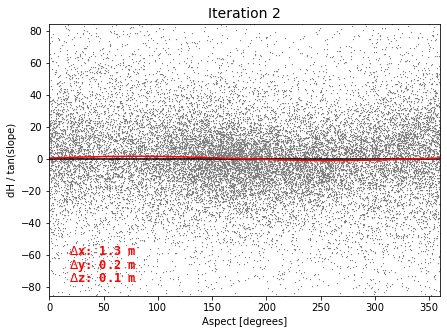

In [17]:
## update the shift values
x_shift += xadj
y_shift += yadj
z_shift += zadj

print(x_shift, y_shift, z_shift)
## 1. rectify the x and y. 
slave_proc.shift(xadj, yadj)        # rectify the slave dem in terms of x and y.
slave_proc = slave_proc.reproject(master_dem)    # re-align the grid of the master, slave DEMs after shifting
## 2. rectify the z.
slave_proc = slave_proc.copy(new_raster=slave_proc.img + zadj) # shift the DEM in the z direction
## 3. co-registration: 3.1 preprocessing, 3.2 co-regionstration
dH, xdata, ydata, sdata = ct.preprocess(mask, \
                      slope_geo.img, aspect_geo.img, master_dem, slave_proc)
# # fig4 = ct.false_hillshade(dH, 'DEM difference after first iteration.')
xadj, yadj, zadj, fig5 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 2')


shift(x,y,z): 4.247680582763653 5.738385739591379 0.3096253175181696


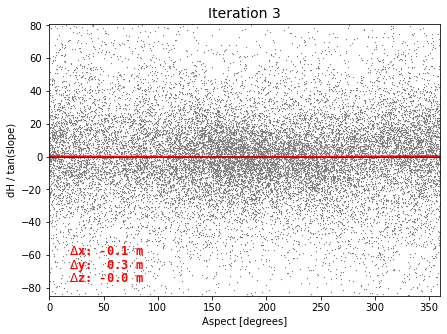

In [18]:
## update the shift values
x_shift += xadj
y_shift += yadj
z_shift += zadj

print('shift(x,y,z):', x_shift, y_shift, z_shift)
## 1. rectify the x and y.
slave_proc.shift(xadj, yadj)        # rectify the slave dem in terms of x and y.
slave_proc = slave_proc.reproject(master_dem)    # re-align the grid of the master, slave DEMs after shifting
## 2. rectify the z.
slave_proc = slave_proc.copy(new_raster=slave_proc.img + zadj) # shift the DEM in the z direction
## 3. co-registration: 3.1 preprocessing, 3.2 co-regionstration
dH, xdata, ydata, sdata = ct.preprocess(mask, \
                      slope_geo.img, aspect_geo.img, master_dem, slave_proc)
# # fig4 = ct.false_hillshade(dH, 'DEM difference after first iteration.')
xadj, yadj, zadj, fig5 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 3')
### final rectify
slave_proc.shift(xadj, yadj)        # rectify the slave dem in terms of x and y.


([-0.45834282, 0.07763672, 9.705071, 9.715892, 7009627],
 [11.108496, 0.32910156, 103.34738, 103.94265, 12065181])

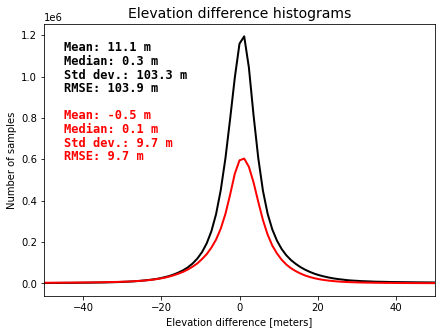

In [19]:
ct.final_histogram(init_dh_geo.img, dH.img) # plot the difference distributions between the two DEMs pre- and post- co-registration.


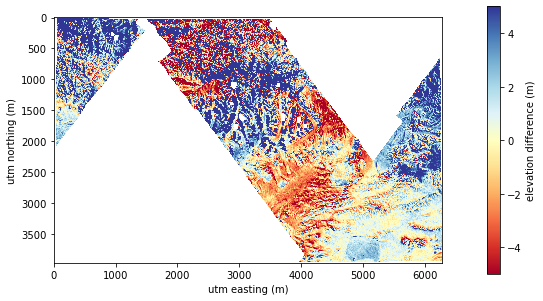

In [20]:

final_dh_geo = slave_dem.copy(new_raster=slave_proc.img - master_dem.img )
# display the new difference image and the old difference image.
fig1 = plt.figure(figsize=(8,8))
plt.imshow(init_dh_geo.img, vmin=-5, vmax=5, cmap='RdYlBu')
fig1.gca().set_xlabel('utm easting (m)')
fig1.gca().set_ylabel('utm northing (m)')
# add a colorbar and set the label
cb = plt.colorbar(fraction=0.03, pad=0.1); 
cb.set_label('elevation difference (m)')


### Save the rectified tandem image

In [22]:
path_tandem_rectify = config.root_proj + '/data/dem/tandem-x/tandem_wkunlun_upsam_utm_align_rectify.tif'
writeTiff(im_data=slave_proc.img, im_geotrans=img_master_info['geotrans'], \
                      im_geosrs=img_master_info['geosrs'], path_out=path_tandem_rectify)
